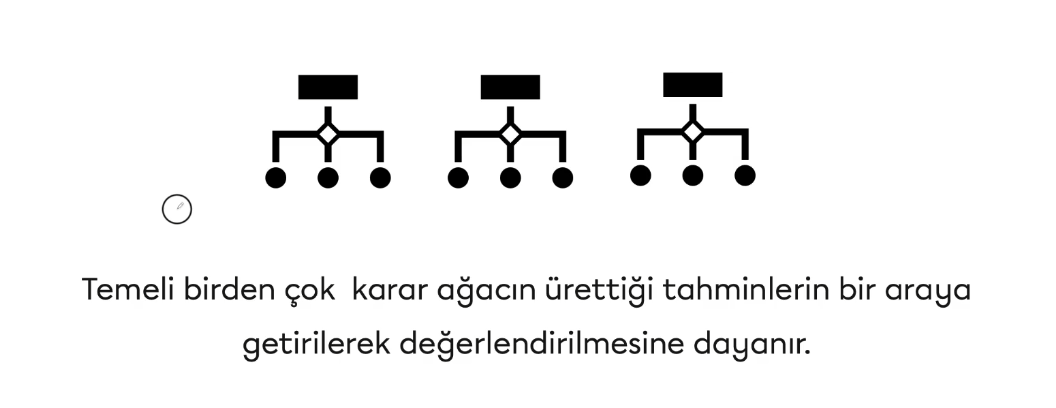

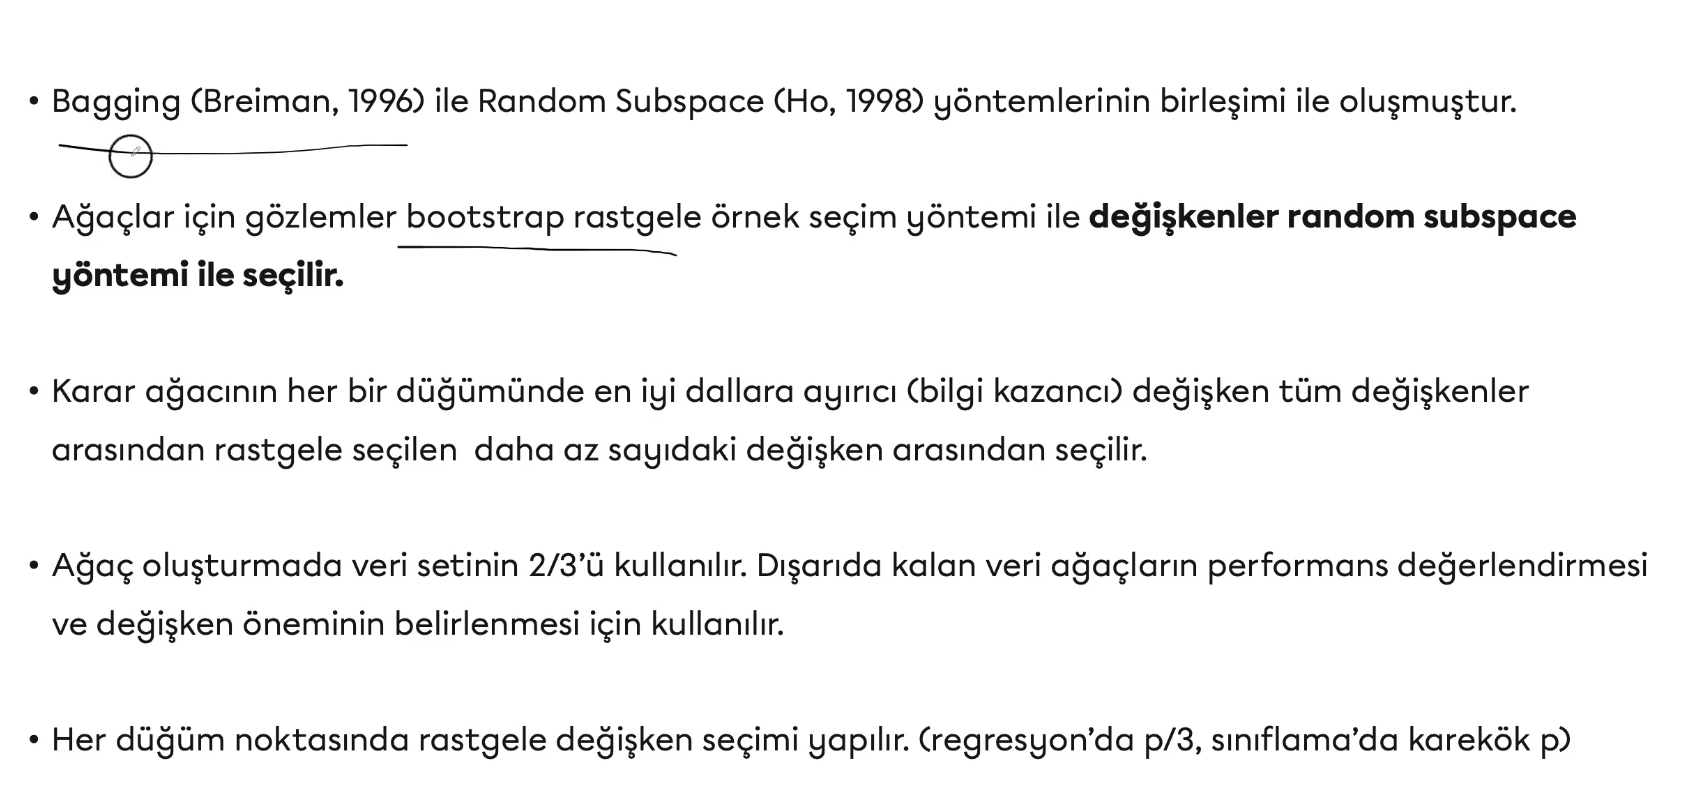

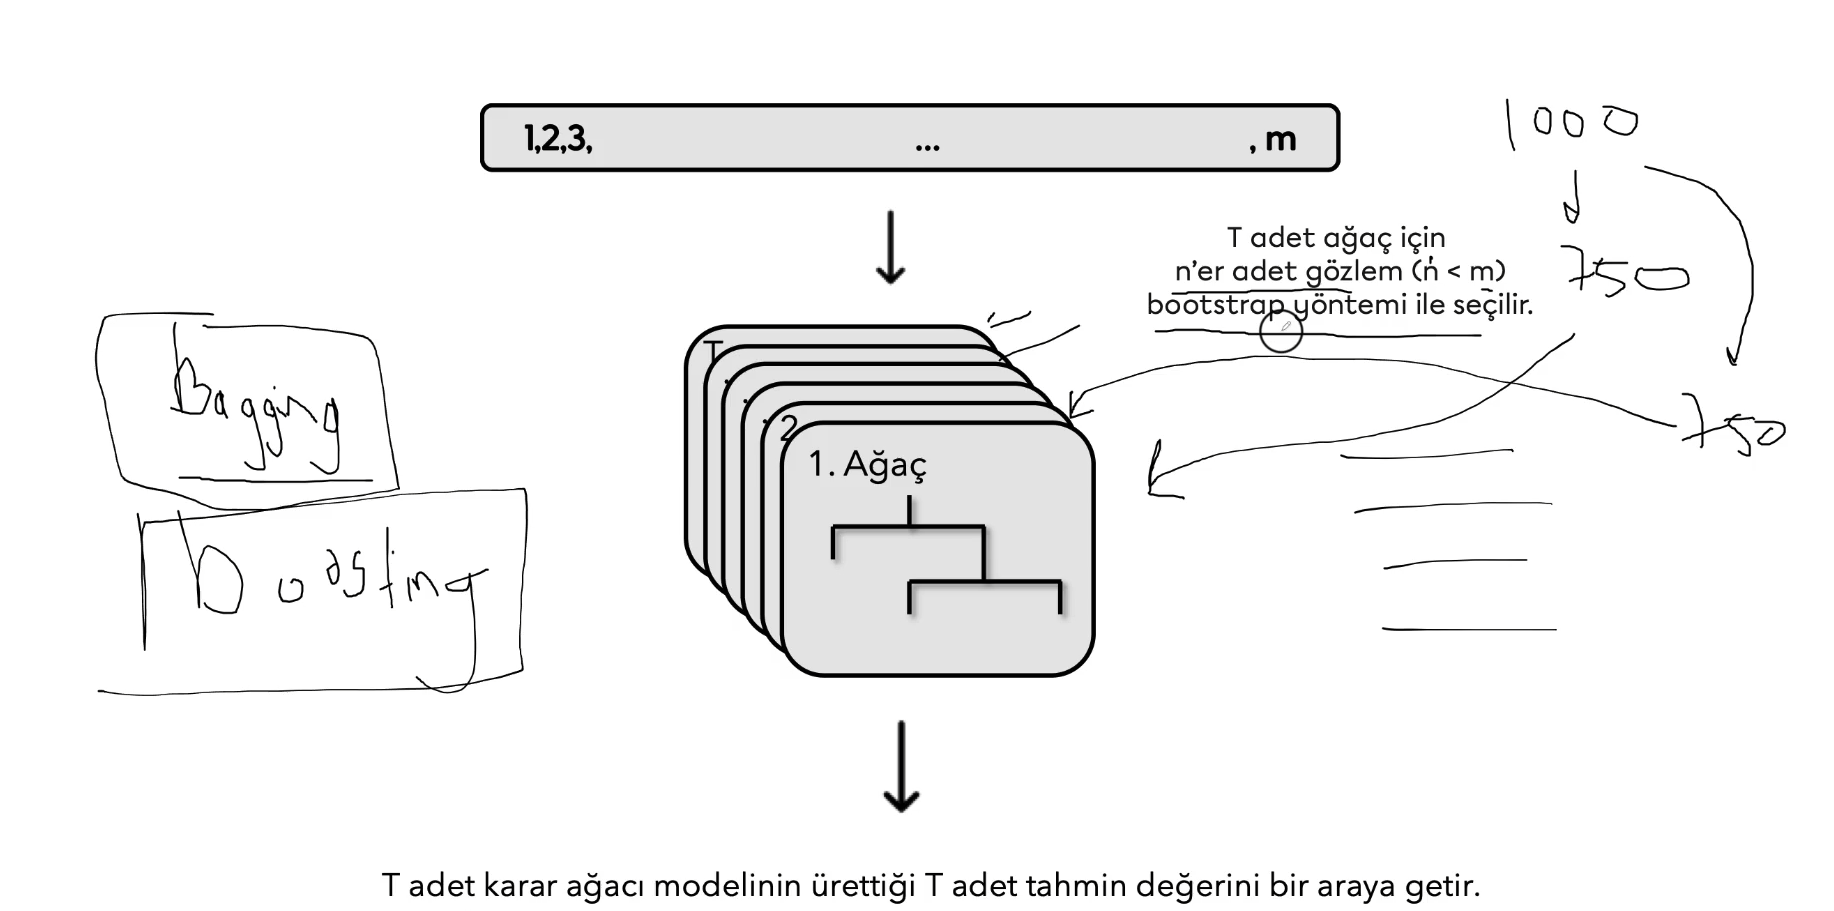

In [1]:
print("sa")

sa


In [3]:
!pip install catboost
!pip install xgboost
!pip install lightgbm


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ----------------------------- ---------- 1.0/1.4 MB 10.1 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 10.8 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [17]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, validation_curve
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
import warnings
import joblib 
import pydotplus 
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier , export_graphviz, export_text
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split,GridSearchCV,cross_validate,validation_curve

In [26]:
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier, RandomForestClassifier







In [60]:
pd.set_option('display.max_columns',None)
warnings.simplefilter(action='ignore',category=Warning)

In [61]:
df = pd.read_csv('../datasets/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [62]:
y=df["Outcome"]

In [63]:
X=df.drop(["Outcome"],axis=1)

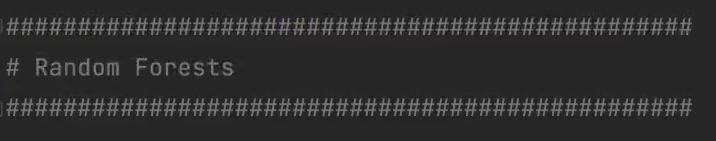

In [64]:
rf_model = RandomForestClassifier(random_state=17)


In [65]:
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 17,
 'verbose': 0,
 'warm_start': False}

In [66]:
cv_result = cross_validate(rf_model,X,y,cv=10,scoring=["accuracy","f1","roc_auc"])

In [67]:
cv_result['test_roc_auc'].mean()


0.8233960113960114

In [68]:
cv_result['test_f1'].mean()


0.6190701534636385

In [69]:
cv_result['test_accuracy'].mean()


0.753896103896104

In [70]:
rf_params = {"max_depth":[5,8,None],
             "max_features":[3,5,7,"auto"],
             "min_samples_split":[2,5,8,15,20],
             "n_estimators":[100,200,500]}

In [71]:
rf_best_grid = GridSearchCV(rf_model,rf_params,cv=5,n_jobs=-1,verbose=True).fit(X,y)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


In [72]:
rf_best_grid.best_params_

{'max_depth': None,
 'max_features': 5,
 'min_samples_split': 8,
 'n_estimators': 500}

In [73]:
rf_final = rf_model.set_params(**rf_best_grid.best_params_,random_state=17).fit(X,y)

In [74]:
cv_result = cross_validate(rf_final,X,y,cv=10,scoring=["accuracy","f1","roc_auc"])

In [75]:
cv_result['test_roc_auc'].mean()


0.8271054131054132

In [76]:
cv_result['test_f1'].mean()


0.6447777811143756

In [77]:
cv_result['test_accuracy'].mean()


0.766848940533151

In [78]:
def plot_importance (model, features, num=len (X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values (by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


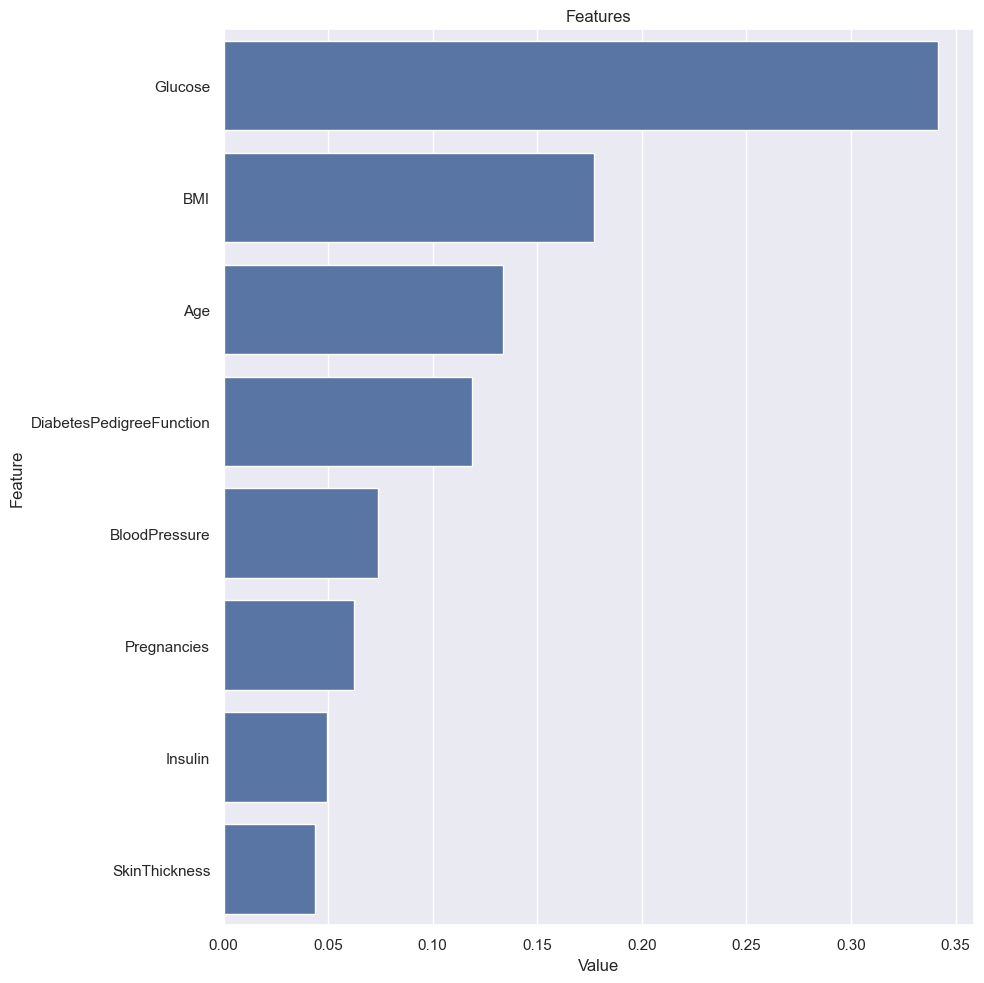

In [79]:
plot_importance(rf_final,X)

In [80]:
def val_curve_params(model, X, y, param_name, param_range, scoring="roc_auc", cv=10):
    """
    Dinamik olarak validation_curve hesaplayan bir fonksiyon.

    Parameters:
        model: Makine öğrenmesi modeli (ör. DecisionTreeClassifier, RandomForestClassifier).
        X: Özellik matrisi (numpy array veya pandas DataFrame).
        y: Hedef değişkeni (numpy array veya pandas Series).
        param_name: Ayarlanacak hiperparametrenin adı (str).
        param_range: Hiperparametre değerlerinin aralığı (list veya range).
        scoring: Değerlendirme metriği (str, varsayılan: "roc_auc").
        cv: Çapraz doğrulama kat sayısı (int, varsayılan: 10).

    Returns:
        train_scores_mean: Eğitim seti skorlarının ortalaması.
        test_scores_mean: Test seti skorlarının ortalaması.
    """
    train_scores, test_scores = validation_curve(
        estimator=model,
        X=X,
        y=y,
        param_name=param_name,
        param_range=param_range,
        scoring=scoring,
        cv=cv
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    # Grafik oluşturma
    plt.figure(figsize=(8, 6))
    plt.plot(param_range, train_scores_mean, label="Training Score", color="b")
    plt.plot(param_range, test_scores_mean, label="Validation Score", color="g")
    plt.title(f"Validation Curve for {type(model).__name__}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(scoring)
    plt.legend(loc="best")
    plt.grid()
    plt.show()

    return train_scores_mean, test_scores_mean


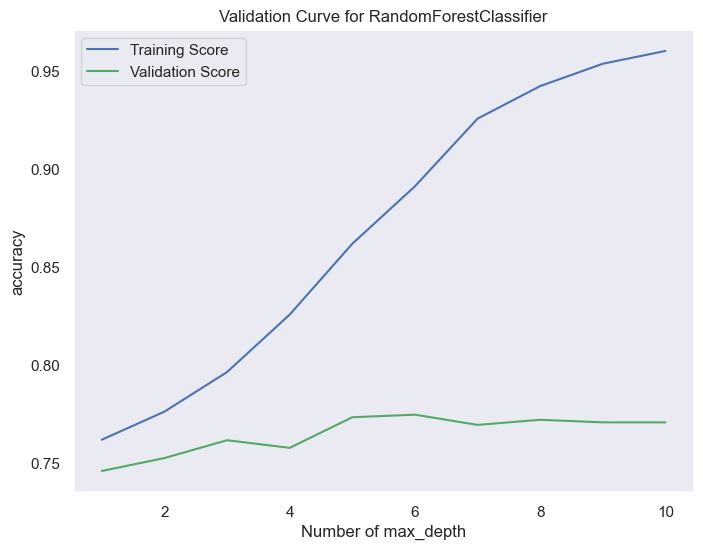

In [81]:
train_score, test_score = val_curve_params(
    model=rf_final,
    X=X,
    y=y,
    param_name="max_depth",
    param_range=range(1, 11),
    scoring="accuracy",
    cv=5
)